### Backtesting.py kasutamine ja erinevad harjutused
#### https://kernc.github.io/backtesting.py/  

In [2]:
pip install backtesting

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Anna\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Anna\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#to import talib
from backtesting import Backtest, Strategy
#from backtesting.test import GOOG
import yfinance as yf
import pandas as pd
from backtesting.lib import crossover, plot_heatmaps, resample_apply, barssince
import talib
import seaborn as sns

Loading BokehJS ...

In [111]:
#import symbol
symbols = ["SLB"] 
df_multiple_symbols = yf.download(symbols, start="2011-01-01", end="2025-01-01")

# Flatten columns because MultiIndex
if isinstance(df_multiple_symbols.columns, pd.MultiIndex):
    df_multiple_symbols.columns = df_multiple_symbols.columns.get_level_values(0)

df_multiple_symbols = df_multiple_symbols.dropna()

[*********************100%***********************]  1 of 1 completed


In [112]:
df_multiple_symbols

Price,Close,High,Low,Open,Volume
Date,,,,,
2011-01-03,57.847916,58.470309,57.654283,58.089956,5429100
2011-01-04,56.450985,58.249012,55.773272,57.958558,8640400
2011-01-05,57.114868,57.190939,55.738691,55.973820,6215800
2011-01-06,55.690269,57.177096,55.143947,57.121771,8257200
2011-01-07,56.402588,56.879757,55.524325,55.711041,6604800
...,...,...,...,...,...
2024-12-24,36.572163,36.610936,35.757940,36.135971,4555400
2024-12-26,36.572163,36.707866,36.106893,36.581858,8145400
2024-12-27,36.640011,37.134362,36.349218,36.484921,9493700


upper_bound  lower_bound  rsi_window
50           5            2            -0.183827
             10           2            -0.275851
             15           2            -0.271956
             20           2            -0.136750
             25           2            -0.203772
                                          ...   
85           25           2            -0.108211
             30           2            -0.073351
             35           2            -0.056151
             40           2             0.026204
             45           2             0.067349
Name: Sharpe Ratio, Length: 72, dtype: float64
Start                     2011-01-03 00:00:00
End                       2024-12-31 00:00:00
Duration                   5111 days 00:00:00
Exposure Time [%]                    71.74901
Equity Final [$]                  16281.64485
Equity Peak [$]                   25314.39457
Return [%]                           62.81645
Buy & Hold Return [%]               -34.93211
Return (A

GridPlot(id='p10181', ...)

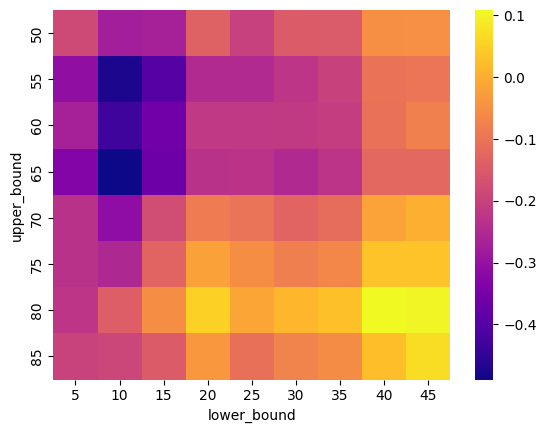

In [113]:
def optim_func(series):

#   filters out precondition 
    if series['Win Rate [%]'] < 75:
        return -1
    return series ['# Trades'] * series ['Return (Ann.) [%]'] 

class RsiOscillator(Strategy):
    
    upper_bound=80
    lower_bound=20
    rsi_window = 14
#    ema_window = 233
    
    #Rsi input from talib
    def init (self):
        self.rsi = self.I(talib.RSI, self.data.Close, self.rsi_window)
#        self.ema = self.I(talib.EMA, self.data.Close, self.ema_window)

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi): #and self.data.Close > self.ema:
            self.buy()

bt = Backtest(df_multiple_symbols, RsiOscillator, cash=10000)

#stats = bt.run()
stats, heatmap = bt.optimize(
    upper_bound = range(50, 90, 5),
    lower_bound = range(5, 50, 5),
    rsi_window = 2,
    # maximize towards
    maximize = "Sharpe Ratio",
    constraint = lambda param: param.upper_bound > param.lower_bound,
    return_heatmap = True
    # max_tries = 100
    )

#lower_bound = stats["_strategy"].lower_bound
print(heatmap)
hm = heatmap.groupby(["upper_bound", "lower_bound"]).mean().unstack()
#print(hm)
print(stats)
sns.heatmap(hm, cmap="plasma")
lower_bound = stats["_strategy"].lower_bound
upper_bound = stats["_strategy"].upper_bound
rsi_window = stats["_strategy"].rsi_window
bt.plot()

In [95]:
# Process the heatmap to get top 50 results
if isinstance(heatmap, pd.Series):
    # Convert Series to DataFrame
    heatmap_df = heatmap.reset_index()
    # The columns will be: upper_bound, lower_bound, rsi_window, and the metric value
    # Let's check what columns we have
    print(f"Heatmap columns: {heatmap_df.columns.tolist()}")
    
    # Rename columns properly
    # The last column is the Sharpe Ratio value
    metric_col = heatmap_df.columns[-1]  # Get the name of the metric column
    heatmap_df = heatmap_df.rename(columns={
        heatmap_df.columns[0]: 'upper_bound',
        heatmap_df.columns[1]: 'lower_bound', 
        heatmap_df.columns[2]: 'rsi_window',
        metric_col: 'Sharpe Ratio'
    })
else:
    # It's already a DataFrame
    heatmap_df = heatmap.reset_index()

print(f"\nHeatmap shape: {heatmap_df.shape}")
print(f"Columns: {heatmap_df.columns.tolist()}")

# Get top 50 by Sharpe Ratio
top_50 = heatmap_df.nlargest(50, 'Sharpe Ratio').copy()

# Create the results table
results_list = []

for idx, row in top_50.iterrows():
    # Run backtest with these parameters to get win rate and total trades
    temp_stats = bt.run(
        upper_bound=int(row['upper_bound']),
        lower_bound=int(row['lower_bound']),
        rsi_window=int(row['rsi_window'])
    )
    
    results_list.append({
        'rsi': int(row['rsi_window']),
        'bottom_value': int(row['lower_bound']),
        'upper_value': int(row['upper_bound']),
        'sharpe_ratio': float(row['Sharpe Ratio']),
        'winrate': float(temp_stats['Win Rate [%]']),
        'total_trades': int(temp_stats['# Trades'])
    })

# Create DataFrame and print
results_df = pd.DataFrame(results_list)

print("\n" + "="*100)
print("TOP 50 RESULTS")
print("="*100)
print(f"{'RSI':^6} {'Bottom':^8} {'Upper':^8} {'Sharpe Ratio':^12} {'Win Rate %':^10} {'Trades':^8}")
print("-"*60)

for _, row in results_df.iterrows():
    print(f"{row['rsi']:^6} {row['bottom_value']:^8} {row['upper_value']:^8} {row['sharpe_ratio']:^12.3f} {row['winrate']:^10.2f} {row['total_trades']:^8}")

print("="*100)
print(f"Total results shown: {len(results_df)}")
print("="*100)

# Also print as a table for easier copying
print("\nResults as DataFrame (for analysis):")
print(results_df.to_string(index=False))

Heatmap columns: ['upper_bound', 'lower_bound', 'rsi_window', 'Sharpe Ratio']

Heatmap shape: (72, 4)
Columns: ['upper_bound', 'lower_bound', 'rsi_window', 'Sharpe Ratio']

TOP 50 RESULTS
 RSI    Bottom   Upper   Sharpe Ratio Win Rate %  Trades 
------------------------------------------------------------
 2.0     20.0     80.0      0.601       75.00     220.0  
 2.0     20.0     75.0      0.587       75.73     239.0  
 2.0     20.0     70.0      0.587       75.30     251.0  
 2.0     15.0     80.0      0.567       74.03     181.0  
 2.0     20.0     65.0      0.564       72.62     263.0  
 2.0     30.0     80.0      0.561       74.62     260.0  
 2.0     35.0     80.0      0.546       73.90     272.0  
 2.0     20.0     85.0      0.544       74.61     193.0  
 2.0     25.0     80.0      0.543       76.47     238.0  
 2.0     25.0     70.0      0.536       72.30     278.0  
 2.0     35.0     75.0      0.533       74.75     305.0  
 2.0     40.0     80.0      0.531       73.90     295.0

In [114]:
#Using Rsi 2-3 testing with Exponential Moving Average of 233 as the long filter
def optim_func(series):

#   filters out precondition winrate vähem kui 70%,max drawdown väiksem kui -30 ja trades vähem kui 150
    if series["Win Rate [%]"] < 70 or series['Max. Drawdown [%]'] < -30 or series ["# Trades"] < 150:
        return -1
    return series ["Win Rate [%]"] * series ["Return (Ann.) [%]"] 
class RsiOscillator(Strategy):
    
    upper_bound=80
    lower_bound=20
    rsi_window = 14
    ema_window = 233

    def init (self):
        self.rsi = self.I(talib.RSI, self.data.Close, self.rsi_window)
        self.ema = self.I(talib.EMA, self.data.Close, self.ema_window)

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi) and self.data.Close > self.ema:
            self.buy()

bt = Backtest(df_multiple_symbols, RsiOscillator, cash=10000)

#stats = bt.run()
#add heatmap next to stats if you want it
stats, heatmap = bt.optimize(
    upper_bound = range(50, 90, 5),
    lower_bound = range(5, 50, 5),
    rsi_window = range(2, 4, 1),
    maximize = optim_func,
    constraint = lambda param: param.upper_bound > param.lower_bound,
    return_heatmap = True
    #max_tries = 100
    )

#lower_bound = stats["_strategy"].lower_bound
#print(heatmap)
#plot_heatmaps(heatmap, agg="mean")

print(stats)
lower_bound = stats["_strategy"].lower_bound
upper_bound = stats["_strategy"].upper_bound
rsi_window = stats["_strategy"].rsi_window
print(stats["_strategy"])
bt.plot()

Start                     2011-01-03 00:00:00
End                       2024-12-31 00:00:00
Duration                   5111 days 00:00:00
Exposure Time [%]                     3.88984
Equity Final [$]                   8992.57935
Equity Peak [$]                    11179.7843
Return [%]                          -10.07421
Buy & Hold Return [%]               -29.25162
Return (Ann.) [%]                    -0.75688
Volatility (Ann.) [%]                 6.83275
CAGR [%]                             -0.52218
Sharpe Ratio                         -0.11077
Sortino Ratio                          -0.145
Calmar Ratio                         -0.03488
Alpha [%]                            -9.06193
Beta                                  0.03461
Max. Drawdown [%]                   -21.69838
Avg. Drawdown [%]                    -3.64005
Max. Drawdown Duration     1395 days 00:00:00
Avg. Drawdown Duration      385 days 00:00:00
# Trades                                   33
Win Rate [%]                      

GridPlot(id='p10600', ...)

In [101]:
import pandas as pd

# Process the heatmap to get top results
if isinstance(heatmap, pd.Series):
    # Convert Series to DataFrame
    heatmap_df = heatmap.reset_index()
    # The columns will be: upper_bound, lower_bound, rsi_window, and the optim_func value
    print(f"Heatmap columns: {heatmap_df.columns.tolist()}")
    
    # Rename columns properly
    metric_col = heatmap_df.columns[-1]  # Get the name of the metric column
    heatmap_df = heatmap_df.rename(columns={
        heatmap_df.columns[0]: 'upper_bound',
        heatmap_df.columns[1]: 'lower_bound', 
        heatmap_df.columns[2]: 'rsi_window',
        metric_col: 'Optim_Value'
    })
else:
    # It's already a DataFrame
    heatmap_df = heatmap.reset_index()

print(f"\nHeatmap shape: {heatmap_df.shape}")
print(f"Columns: {heatmap_df.columns.tolist()}")

# Filter out invalid results (optim_func returns -1 for failed conditions)
valid_results = heatmap_df[heatmap_df['Optim_Value'] > 0].copy()

if len(valid_results) > 0:
    # Get top 50 by Optim_Value (or all if less than 50)
    top_n = valid_results.nlargest(50, 'Optim_Value').copy()
    
    # Create the results table
    results_list = []
    
    for idx, row in top_n.iterrows():
        # Run backtest with these parameters to get detailed stats
        temp_stats = bt.run(
            upper_bound=int(row['upper_bound']),
            lower_bound=int(row['lower_bound']),
            rsi_window=int(row['rsi_window']),
            ema_window=233  # Fixed as per your strategy
        )
        
        results_list.append({
            'rsi': int(row['rsi_window']),
            'bottom_value': int(row['lower_bound']),
            'upper_value': int(row['upper_bound']),
            'sharpe_ratio': float(temp_stats['Sharpe Ratio']),  # Extracting Sharpe Ratio
            'winrate': float(temp_stats['Win Rate [%]']),
            'total_trades': int(temp_stats['# Trades']),
            'annual_return': float(temp_stats['Return (Ann.) [%]']),
            'max_drawdown': float(temp_stats['Max. Drawdown [%]']),
            'optim_value': float(row['Optim_Value'])  # The value from your optim_func
        })
    
    # Create DataFrame and print
    results_df = pd.DataFrame(results_list)
    
    # Sort by Sharpe Ratio for the display table
    results_df_sorted = results_df.sort_values('sharpe_ratio', ascending=False).reset_index(drop=True)
    
    print("\n" + "="*120)
    print("TOP 50 RESULTS (by Optim Function)")
    print("="*120)
    
    # Print the requested table: Rsi value, lower value, upper value, Sharpe ratio, Winrate
    print(f"{'RSI':^6} {'Bottom':^8} {'Upper':^8} {'Sharpe Ratio':^12} {'Win Rate %':^10}")
    print("-"*60)
    
    for _, row in results_df_sorted.iterrows():
        print(f"{row['rsi']:^6} {row['bottom_value']:^8} {row['upper_value']:^8} {row['sharpe_ratio']:^12.3f} {row['winrate']:^10.2f}")
    
    print("="*120)
    print(f"Total valid results shown: {len(results_df_sorted)} out of {len(valid_results)} valid combinations")
    print("="*120)
    
    # Also print extended table for analysis
    print("\nExtended Results Table (for analysis):")
    print(results_df_sorted[['rsi', 'bottom_value', 'upper_value', 'sharpe_ratio', 'winrate', 
                           'total_trades', 'annual_return', 'max_drawdown', 'optim_value']].to_string(index=False))
    
    # Find the best by Sharpe Ratio
    best_sharpe = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    print(f"\nBest by Sharpe Ratio: RSI={best_sharpe['rsi']}, Bottom={best_sharpe['bottom_value']}, "
          f"Upper={best_sharpe['upper_value']}, Sharpe={best_sharpe['sharpe_ratio']:.3f}, "
          f"Winrate={best_sharpe['winrate']:.2f}%")
    
    # Find the best by Optim Value (your original criteria)
    best_optim = results_df.loc[results_df['optim_value'].idxmax()]
    print(f"Best by Optim Function: RSI={best_optim['rsi']}, Bottom={best_optim['bottom_value']}, "
          f"Upper={best_optim['upper_value']}, Sharpe={best_optim['sharpe_ratio']:.3f}, "
          f"Winrate={best_optim['winrate']:.2f}%")


Heatmap columns: ['upper_bound', 'lower_bound', 'rsi_window', 0]

Heatmap shape: (144, 4)
Columns: ['upper_bound', 'lower_bound', 'rsi_window', 'Optim_Value']

TOP 50 RESULTS (by Optim Function)
 RSI    Bottom   Upper   Sharpe Ratio Win Rate %
------------------------------------------------------------
 2.0     20.0     55.0      0.718       72.17   
 2.0     20.0     60.0      0.711       73.43   
 2.0     20.0     50.0      0.704       71.49   
 2.0     20.0     70.0      0.701       77.13   
 3.0     35.0     50.0      0.699       70.74   
 3.0     30.0     50.0      0.696       72.53   
 2.0     40.0     70.0      0.681       71.38   
 3.0     35.0     60.0      0.679       77.16   
 2.0     35.0     70.0      0.670       71.43   
 2.0     25.0     55.0      0.670       70.68   
 2.0     20.0     65.0      0.663       73.87   
 2.0     15.0     55.0      0.657       70.66   
 2.0     25.0     60.0      0.650       72.80   
 3.0     30.0     60.0      0.644       75.95   
 3.0     

In [ ]:
#Testing dow jones 30 stocks and picking best average indicator conditions
# Define the list of Dow Jones 30 stocks
dow_jones_30 = [
    "AAPL", "MSFT", "KO","PM", "MU", "BSX", "KLAC", "SO", "CL", "FCX", "TGT", "SLB", "PYPL", 
    "USB", "MMM", "WMB", "AEP", "KR", "FITB", "CNP"
]

# Function to optimize
def optim_func(series):
    if series["Win Rate [%]"] < 72 or series['# Trades'] < 130 or series['Max. Drawdown [%]'] < -25:
        return -1
    return series["Win Rate [%]"] * series["Return [%]"]

# Strategy class
class RsiOscillator(Strategy):
    upper_bound = 80
    lower_bound = 20
    rsi_window = 14


    def init(self):
        self.rsi = self.I(talib.RSI, self.data.Close, self.rsi_window)

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi) :
            self.buy()

# Function to run backtest for a single stock
def backtest_stock(symbol):
    df = yf.download(symbol, start="2010-01-01", end="2024-03-03")
    bt = Backtest(df, RsiOscillator, cash=10000)
    stats = bt.optimize(
        upper_bound=range(50, 90, 5),
        lower_bound=range(5, 50, 5),
        rsi_window=range(2, 5, 1),
        maximize=optim_func,
        constraint=lambda param: param.upper_bound > param.lower_bound
    )
    return stats

# Collect results for all stocks
results = []
optimal_params = []
for symbol in dow_jones_30:
    print(f"Running backtest for {symbol}")
    result = backtest_stock(symbol)
    results.append(result)
    optimal_params.append({
        'symbol': symbol,
        'lower_bound': result['_strategy'].lower_bound,
        'upper_bound': result['_strategy'].upper_bound,
        'rsi_window': result['_strategy'].rsi_window
    })

# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_optimal_params = pd.DataFrame(optimal_params)

# Calculate average optimal parameters
average_params = df_optimal_params.median(numeric_only=True)

# Calculate average statistics
average_stats = df_results.mean(numeric_only=True)

print("Average Statistics for Dow Jones 30:")
print(average_stats)

# Print the optimal parameters for reference
for symbol, stats in zip(dow_jones_30, results):
    print(f"{symbol}:")
    print(f"  lower_bound: {stats['_strategy'].lower_bound}")
    print(f"  upper_bound: {stats['_strategy'].upper_bound}")
    print(f"  rsi_window: {stats['_strategy'].rsi_window}")

print("Average Optimal Parameters for Dow Jones 30:")
print(f"Average lower_bound: {average_params['lower_bound']}")
print(f"Average upper_bound: {average_params['upper_bound']}")
print(f"Average RSI window: {average_params['rsi_window']}")

# Example to print the optimal parameters for the first stock
# lower_bound = results[0]["_strategy"].lower_bound
# upper_bound = results[0]["_strategy"].upper_bound
# rsi_window = results[0]["_strategy"].rsi_window
# print(results[0]["_strategy"])


In [108]:
# Testing dow jones 30 stocks and picking best average indicator conditions
# Define the list of Dow Jones 30 stocks
dow_jones_30 = [
    "AAPL", "MSFT", "KO","PM", "MU", "BSX", "KLAC", "SO", "CL", "FCX", "TGT", "SLB", "PYPL", 
    "USB", "MMM", "WMB", "AEP", "KR", "FITB", "CNP"
]

# Function to optimize
def optim_func(series):
    if series["Win Rate [%]"] < 72 or series['# Trades'] < 130 or series['Max. Drawdown [%]'] < -25:
        return -1
    return series["Win Rate [%]"] * series["Return [%]"]

# Strategy class
class RsiOscillator(Strategy):
    upper_bound = 80
    lower_bound = 20
    rsi_window = 14

    def init(self):
        self.rsi = self.I(talib.RSI, self.data.Close, self.rsi_window)

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi):
            self.buy()

# Function to run backtest for a single stock
def backtest_stock(symbol):
    # Download data
    df_temp = yf.download(symbol, start="2010-01-01", end="2024-03-03")
    
    # Fix column structure - yf.download returns MultiIndex even for single symbol
    if isinstance(df_temp.columns, pd.MultiIndex):
        df = df_temp.xs(symbol, axis=1, level=1)
    else:
        df = df_temp
    
    # Ensure we have required columns
    required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing column {col} in data for {symbol}")
    
    bt = Backtest(df, RsiOscillator, cash=10000)
    stats = bt.optimize(
        upper_bound=range(50, 90, 5),
        lower_bound=range(5, 50, 5),
        rsi_window=range(2, 5, 1),
        maximize=optim_func,
        constraint=lambda param: param.upper_bound > param.lower_bound
    )
    return stats, bt

# Collect results for all stocks
results = []
optimal_params = []
backtest_objects = []

for symbol in dow_jones_30:
    print(f"Running backtest for {symbol}")
    try:
        stats, bt = backtest_stock(symbol)
        results.append(stats)
        optimal_params.append({
            'symbol': symbol,
            'lower_bound': stats['_strategy'].lower_bound,
            'upper_bound': stats['_strategy'].upper_bound,
            'rsi_window': stats['_strategy'].rsi_window,
            'sharpe_ratio': stats['Sharpe Ratio'],
            'win_rate': stats['Win Rate [%]'],
            'total_trades': stats['# Trades'],
            'annual_return': stats['Return (Ann.) [%]'],
            'max_drawdown': stats['Max. Drawdown [%]']
        })
        backtest_objects.append(bt)
    except Exception as e:
        print(f"Error processing {symbol}: {e}")
        continue

# Convert results to DataFrame
df_optimal_params = pd.DataFrame(optimal_params)

# Calculate average optimal parameters (using median to avoid outliers)
average_params = df_optimal_params.median(numeric_only=True)

print("\n" + "="*80)
print("OPTIMAL PARAMETERS FOR EACH STOCK")
print("="*80)
print(df_optimal_params[['symbol', 'rsi_window', 'lower_bound', 'upper_bound', 
                         'sharpe_ratio', 'win_rate', 'total_trades']].to_string(index=False))

print("\n" + "="*80)
print("AVERAGE OPTIMAL PARAMETERS (MEDIAN)")
print("="*80)
print(f"Average RSI window: {average_params['rsi_window']:.1f}")
print(f"Average lower_bound: {average_params['lower_bound']:.1f}")
print(f"Average upper_bound: {average_params['upper_bound']:.1f}")
print(f"Average Sharpe Ratio: {average_params['sharpe_ratio']:.3f}")
print(f"Average Win Rate: {average_params['win_rate']:.2f}%")
print(f"Average Total Trades: {average_params['total_trades']:.0f}")
print(f"Average Annual Return: {average_params['annual_return']:.2f}%")
print(f"Average Max Drawdown: {average_params['max_drawdown']:.2f}%")

# Run backtest with average parameters
print("\n" + "="*80)
print("BACKTEST WITH AVERAGE PARAMETERS")
print("="*80)

# Get first stock's data for testing average parameters
symbol = dow_jones_30[0]
df_temp = yf.download(symbol, start="2010-01-01", end="2024-03-03")
if isinstance(df_temp.columns, pd.MultiIndex):
    df = df_temp.xs(symbol, axis=1, level=1)
else:
    df = df_temp

bt_average = Backtest(df, RsiOscillator, cash=10000)
stats_average = bt_average.run(
    upper_bound=int(round(average_params['upper_bound'])),
    lower_bound=int(round(average_params['lower_bound'])),
    rsi_window=int(round(average_params['rsi_window']))
)

print(f"Testing average parameters on {symbol}:")
print(f"  RSI Window: {int(round(average_params['rsi_window']))}")
print(f"  Lower Bound: {int(round(average_params['lower_bound']))}")
print(f"  Upper Bound: {int(round(average_params['upper_bound']))}")
print(f"  Sharpe Ratio: {stats_average['Sharpe Ratio']:.3f}")
print(f"  Win Rate: {stats_average['Win Rate [%]']:.2f}%")
print(f"  Total Trades: {stats_average['# Trades']}")

[*********************100%***********************]  1 of 1 completed

Running backtest for AAPL


Running backtest for MSFT


[*********************100%***********************]  1 of 1 completed


Running backtest for KO


[*********************100%***********************]  1 of 1 completed


Running backtest for PM


[*********************100%***********************]  1 of 1 completed


Running backtest for MU


[*********************100%***********************]  1 of 1 completed


Running backtest for BSX


[*********************100%***********************]  1 of 1 completed


Running backtest for KLAC


[*********************100%***********************]  1 of 1 completed


Running backtest for SO


[*********************100%***********************]  1 of 1 completed


Running backtest for CL


[*********************100%***********************]  1 of 1 completed


Running backtest for FCX


[*********************100%***********************]  1 of 1 completed


Running backtest for TGT


[*********************100%***********************]  1 of 1 completed


Running backtest for SLB


[*********************100%***********************]  1 of 1 completed


Running backtest for PYPL


[*********************100%***********************]  1 of 1 completed


Running backtest for USB


[*********************100%***********************]  1 of 1 completed


Running backtest for MMM


[*********************100%***********************]  1 of 1 completed


Running backtest for WMB


[*********************100%***********************]  1 of 1 completed


Running backtest for AEP


[*********************100%***********************]  1 of 1 completed


Running backtest for KR


[*********************100%***********************]  1 of 1 completed


Running backtest for FITB


[*********************100%***********************]  1 of 1 completed


Running backtest for CNP


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


OPTIMAL PARAMETERS FOR EACH STOCK
symbol  rsi_window  lower_bound  upper_bound  sharpe_ratio  win_rate  total_trades
  AAPL           2           10           60      0.671640 72.625698           179
  MSFT           3           35           75      0.826308 78.494624           186
    KO           2            5           50      0.430831 63.440860            93
    PM           2            5           50     -0.449185 51.000000           100
    MU           2            5           50      0.244195 62.745098           102
   BSX           2            5           50      0.564599 65.934066            91
  KLAC           2            5           50      0.218926 68.235294            85
    SO           2           10           65      0.126071 74.172185           151
    CL           3           45           80      0.727073 77.659574           188
   FCX           2            5           50     -0.192819 57.017544           114
   TGT           2            5           50     -0.

Testing average parameters on AAPL:
  RSI Window: 2
  Lower Bound: 5
  Upper Bound: 50
  Sharpe Ratio: 0.854
  Win Rate: 67.68%
  Total Trades: 99


[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Start                     2009-01-02 00:00:00
End                       2023-12-29 00:00:00
Duration                   5474 days 00:00:00
Exposure Time [%]                   38.288288
Equity Final [$]                 37667.661697
Equity Peak [$]                  37667.661697
Return [%]                         276.676617
Buy & Hold Return [%]               411.30594
Return (Ann.) [%]                    9.259437
Volatility (Ann.) [%]                15.05583
Sharpe Ratio                         0.615007
Sortino Ratio                        0.972344
Calmar Ratio                         0.322249
Max. Drawdown [%]                   -28.73376
Avg. Drawdown [%]                   -2.427358
Max. Drawdown Duration      792 days 00:00:00
Avg. Drawdown Duration       38 days 00:00:00
# Trades                                   99
Win Rate [%]                        74.747475
Best Trade [%]                      11.037396
Worst Trade [%]                    -10.923303
Avg. Trade [%]                    

/home/liisa/miniconda3/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/home/liisa/miniconda3/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p8542', ...)

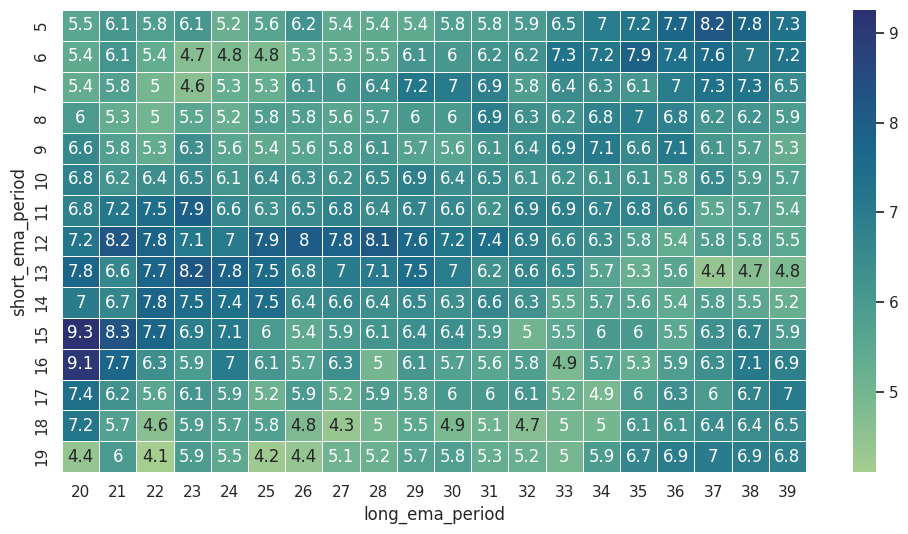

In [58]:
# Define the symbol and data
symbol = "SPY"
df = yf.download(symbol, start="2009-01-01", end="2024-01-01")

#Chart size
sns.set(rc={"figure.figsize":(12, 6)})

# Function to optimize
def optim_func(series):
    if series["Win Rate [%]"] < 70:
        return -1
    return series["Return (Ann.) [%]"]

# Strategy class
class EmaOscillator(Strategy):
    short_ema_period = 5
    long_ema_period = 5

    def init(self):
        self.short_ema = self.I(talib.SMA, self.data.Close, self.short_ema_period)
        self.long_ema = self.I(talib.SMA, self.data.Close, self.long_ema_period)

    def next(self):
        # If short EMA crosses below long EMA
        if crossover(self.short_ema, self.long_ema):
            self.position.close()
        elif crossover(self.long_ema, self.short_ema):
            self.buy()

# Backtest and optimize
bt = Backtest(df, EmaOscillator, cash=10000)

stats, heatmap = bt.optimize(
    short_ema_period=range(5, 20, 1),
    long_ema_period=range(20,40,1),
    maximize="Return (Ann.) [%]",
    return_heatmap = True,
)

print(stats)
print(f"Optimal short EMA period: {stats['_strategy'].short_ema_period}")
print(f"Optimal long EMA period: {stats['_strategy'].long_ema_period}")

# Example to print the optimal parameters for the first stock
#lower_bound = stats["_strategy"].short_ema_period
#print(stats["_strategy"])
#bt.plot()
#lower_bound = stats["_strategy"].lower_bound
print(heatmap)
hm = heatmap.groupby(["short_ema_period", "long_ema_period"]).mean().unstack()
print(hm)
print(stats)
#crearing heatmap
sns.heatmap(hm, cmap="crest", annot=True, linewidths=.5)
bt.plot()

short_ema_period  long_ema_period
5                 20                 5.542255
                  21                 6.050984
                  22                 5.780708
                  23                 6.087364
                  24                 5.210915
                                       ...   
19                35                 6.672671
                  36                 6.945606
                  37                 6.990549
                  38                 6.938031
                  39                 6.835949
Name: Return (Ann.) [%], Length: 300, dtype: float64


<Axes: xlabel='long_ema_period', ylabel='short_ema_period'>

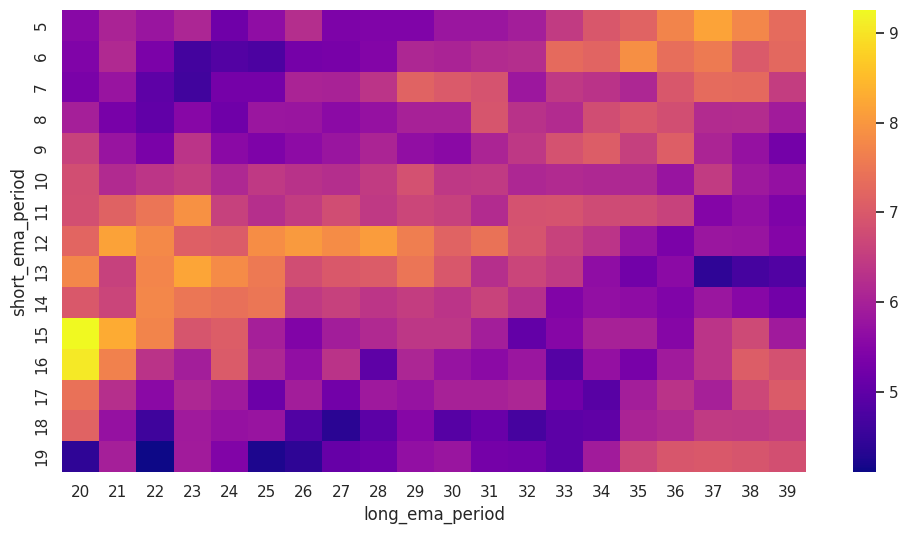

In [64]:
print(heatmap)
hm = heatmap.groupby(["short_ema_period", "long_ema_period"]).mean().unstack()
#print(hm)
#print(stats)
sns.heatmap(hm, cmap="plasma")
#bt.plot()

In [57]:
# Define the list of SP_100 stocks
sp_100 = [
    "AAPL", "ABBV", "ABT", "ACN", "ADBE", "AIG", "ALL", "AMGN", "AMT", "AMZN", 
    "AVGO", "AXP", "BA", "BAC", "BK", "BKNG", "BLK", "BMY", "C", 
    "CAT", "CHTR", "CL", "CMCSA", "COF", "COP", "COST", "CSCO", "CVS", "CVX", 
    "DHR", "DIS", "DUK", "EMR", "EXC", "F", "FDX", "GD", "GE", "GILD", 
    "GM", "GOOGL", "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KHC", 
    "KO", "LIN", "LLY", "LMT", "LOW", "MA", "MCD", "MDLZ", "MDT", "MET", 
    "META", "MMM", "MRK", "MS", "MSFT", "NEE", "NFLX", "NKE", "NVDA", "ORCL", 
    "PEP", "PFE", "PG", "PM", "PYPL", "QCOM", "RTX", "SBUX", "SCHW", "SO", 
    "SPGI", "T", "TGT", "TMO", "TMUS", "TSLA", "TXN", "UNH", "UNP", "UPS", 
    "V", "VZ", "WBA", "WFC", "WMT", "XOM"
]

# Function to optimize
def optim_func(series):
    if series["Win Rate [%]"] < 80:
        return -1
    return series["Sortino Ratio"]

# Strategy class
# Mean reversion trade ,if price is above long moving average it buys when it closes below short term EMA
class EmaOscillator(Strategy):
    short_ema_period = 20
    long_ema_period = 233

    def init(self):
        self.short_ema = self.I(talib.EMA, self.data.Close, self.short_ema_period)
        self.long_ema = self.I(talib.EMA, self.data.Close, self.long_ema_period)

    def next(self):
        if self.data.Close[-1] > self.long_ema[-1]:  # Price must be above the long-term EMA
            if crossover(self.data.Close, self.short_ema):
                self.position.close()
            elif crossover(self.short_ema, self.data.Close):
                self.buy()

# Function to run backtest for a single stock
def backtest_stock(symbol):
    df = yf.download(symbol, start="2009-01-01", end="2024-01-01")
    bt = Backtest(df, EmaOscillator, cash=10000)
    stats = bt.optimize(
        short_ema_period=range(5, 30, 1),
        maximize=optim_func
    )
    return stats

# Collect results for all stocks
results = []
optimal_params = []

for symbol in sp_100:
    print(f"Running backtest for {symbol}")
    result = backtest_stock(symbol)
    results.append(result)
    optimal_params.append(result['_strategy'].short_ema_period)

# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_optimal_params = pd.DataFrame(optimal_params, columns=['short_ema_period'])

# Calculate average optimal parameters
average_params = df_optimal_params.median(numeric_only=True)

# Calculate average statistics
average_stats = df_results.mean(numeric_only=True)

print("Average Optimal Parameters for SPY100:")
print(f"Median short EMA period: {average_params['short_ema_period']}")

print("Average Statistics for SPY100 30:")
print(average_stats)

# Optional: Print the optimal parameters for each stock
for symbol, stats in zip(sp_100, results):
    print(f"{symbol}: Optimal short EMA period: {stats['_strategy'].short_ema_period}")


Running backtest for AAPL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for ABBV
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for ABT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for ACN
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for ADBE
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for AIG
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for ALL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for AMGN
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for AMT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for AMZN
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for AVGO
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for AXP
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for BA
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for BAC
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for BK
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for BKNG
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for BLK
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for BMY
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for C
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CAT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CHTR
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CMCSA
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for COF
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for COP
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for COST
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CSCO
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CVS
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CVX
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for DHR
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for DIS
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for DUK
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for EMR
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for EXC
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for F
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for FDX
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for GD
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for GE
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for GILD
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for GM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for GOOGL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for GS
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for HD
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for HON
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for IBM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for INTC
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for JNJ
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for JPM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for KHC
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for KO
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for LIN
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for LLY
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for LMT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for LOW
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MA
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MCD
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MDLZ
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MDT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MET
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for META
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MMM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MRK
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MS
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MSFT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for NEE
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for NFLX
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for NKE
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for NVDA
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for ORCL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for PEP
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for PFE
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for PG
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for PM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for PYPL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for QCOM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for RTX
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for SBUX
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for SCHW
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for SO
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for SPGI
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for T
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for TGT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for TMO
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for TMUS
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for TSLA
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for TXN
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for UNH
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for UNP
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for UPS
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for V
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for VZ
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for WBA
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for WFC
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for WMT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for XOM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Average Optimal Parameters for SPY100:
Median short EMA period: 5.0
Average Statistics for SPY100 30:
Exposure Time [%]           52.687706
Equity Final [$]         34962.259344
Equity Peak [$]          40352.394952
Return [%]                 249.622593
Buy & Hold Return [%]     1225.275635
Return (Ann.) [%]            7.094865
Volatility (Ann.) [%]       21.460940
Sharpe Ratio                 0.344900
Sortino Ratio                0.565080
Calmar Ratio                 0.202854
Max. Drawdown [%]          -43.312496
Avg. Drawdown [%]           -4.199222
# Trades                   275.957895
Win Rate [%]                69.781624
Best Trade [%]              11.835306
Worst Trade [%]            -20.333306
Avg. Trade [%]               0.411117
Profit Factor                1.933235
Expectancy [%]               0.466315
SQN                          2.121986
dtype: float64
AAPL: Optimal short EMA period: 5
ABBV: Optimal short EMA period: 22
ABT: Optimal short EMA period: 25
ACN: Optimal short E